In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime as dt
from empiricaldist import Cdf
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
from scipy import stats
from matplotlib import colors
from matplotlib.colors import ListedColormap

#Removes Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

In [3]:
df = pd.read_csv('data.csv',encoding= 'unicode_escape', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.isna().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# drop missing data
df.dropna(subset = ['CustomerID'], inplace = True)

In [7]:
# drop missing data
df.dropna(subset = ['InvoiceNo'], inplace = True)
df.isna().sum()


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [8]:
# convert CustomerID dtype to int64
df['CustomerID'] = df['CustomerID'].astype('int64')
assert df['CustomerID'].dtype == 'int64'

In [9]:
# convert InvoiceNo dtype to int64
df['InvoiceNo'] = pd.to_numeric(df['InvoiceNo'], errors='coerce')

In [10]:
# drop complete duplicates
df.drop_duplicates(inplace=True)

In [11]:
# drop UnitPrice = 0 data because it is missing data
df = df[df['UnitPrice'] != 0]
df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,401564.000000,401564.000000
mean,12.149911,3.474410
std,249.512649,69.767501
min,-80995.000000,0.001000
25%,2.000000,1.250000
50%,5.000000,1.950000
75%,12.000000,3.750000
max,80995.000000,38970.000000


In [12]:
# create extra column 'TotalSum'
df['TotalSum'] = df['Quantity'] * df['UnitPrice']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401564 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  float64       
 1   StockCode    401564 non-null  object        
 2   Description  401564 non-null  object        
 3   Quantity     401564 non-null  int64         
 4   InvoiceDate  401564 non-null  datetime64[ns]
 5   UnitPrice    401564 non-null  float64       
 6   CustomerID   401564 non-null  int64         
 7   Country      401564 non-null  object        
 8   TotalSum     401564 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 30.6+ MB


In [13]:
df = df[df['TotalSum']> 0]

In [14]:
# make sure our data is for 12 months from  2010-12-01 to 2011-12-01
print(df['InvoiceDate'].min(), df['InvoiceDate'].max())


2010-12-01 08:26:00 2011-12-09 12:50:00


In [15]:
df= df[df['InvoiceDate'] <= '2011-12-01']
print(df['InvoiceDate'].min(), df['InvoiceDate'].max())



2010-12-01 08:26:00 2011-11-30 17:37:00


In [16]:
# assign acquisition month cohort
# create a function that truncate a given date object to a first day of the month
def get_month(x): 
    return dt.datetime(x.year, x.month, 1)

In [17]:
# create 'InvoiceMonth' column
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)

In [18]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum,InvoiceMonth
0,536365.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01
1,536365.0,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
2,536365.0,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01
3,536365.0,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01
4,536365.0,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01


In [19]:
# assign minimum 'InvoiceMonth' value to 'CohortMonth' column
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [20]:
# calculate time offset for each transaction which is anumber of months 
# between any transaction and first transaction for each customer
# first extract year, month and day
def get_data_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# create two objects with year and month integer values
invoice_year, invoice_month, _ = get_data_int(df, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_data_int(df, 'CohortMonth')

# compute the difference between them
years_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month

# convert the total difference to month
df['CohortIndex'] = years_diff * 12 + month_diff + 1 # + 1 means the first month is marked as 1



In [21]:
# compute the number of monthly active customers in each cohort
# first convert 'CohortMonth' dtype to strftime
df['CohortMonth'] = df['CohortMonth'].dt.strftime('%Y-%m-%d')

# count the number of unique customers in each group
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()

# create a pivot with monthly active customers
cohort_counts = cohort_data.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'CustomerID')

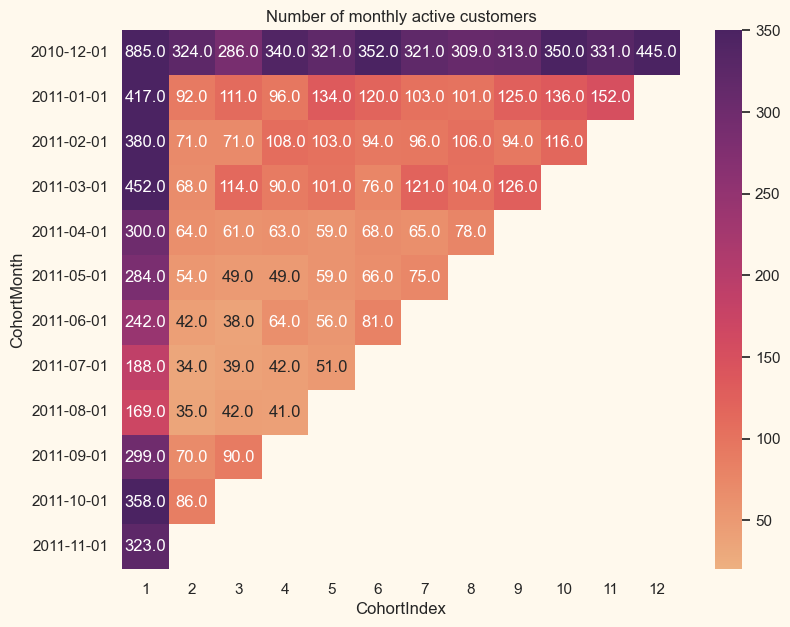

In [22]:
# visualize cohort_count
plt.figure(figsize = (9, 7))
sns.heatmap(data = cohort_counts, annot=True, cmap='flare', fmt='.1f', vmin=20, vmax=350)
plt.title('Number of monthly active customers')
plt.show()

In [23]:
# compute retention rate
cohort_sizes = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

# cumpute churn rate
churn = 1 - retention

# calculate the average quantity of unit for a single invoice
cohort_quantity = df.groupby(['CohortMonth', 'CohortIndex'])['Quantity'].mean().reset_index()
average_quantity = cohort_quantity.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'Quantity')

# calculate the average unit sum for a single purchase
cohort_sum = df.groupby(['CohortMonth', 'CohortIndex'])['TotalSum'].mean().reset_index()
average_sum = cohort_sum.pivot(index = 'CohortMonth', columns = 'CohortIndex', values = 'TotalSum')

In [24]:
# compute overall mean across all four metrics
print('Overall mean retention: ', round(retention.iloc[:, 1:].mean().mean(), 3))
print('Overall mean churn: ', round(churn.iloc[:, 1:].mean().mean(), 3))
print('Overall mean quantity: ', round(average_quantity.mean().mean(), 1))
print('Overall mean sum: ', round(average_sum.mean().mean(), 1))

Overall mean retention:  0.298
Overall mean churn:  0.702
Overall mean quantity:  12.5
Overall mean sum:  21.4


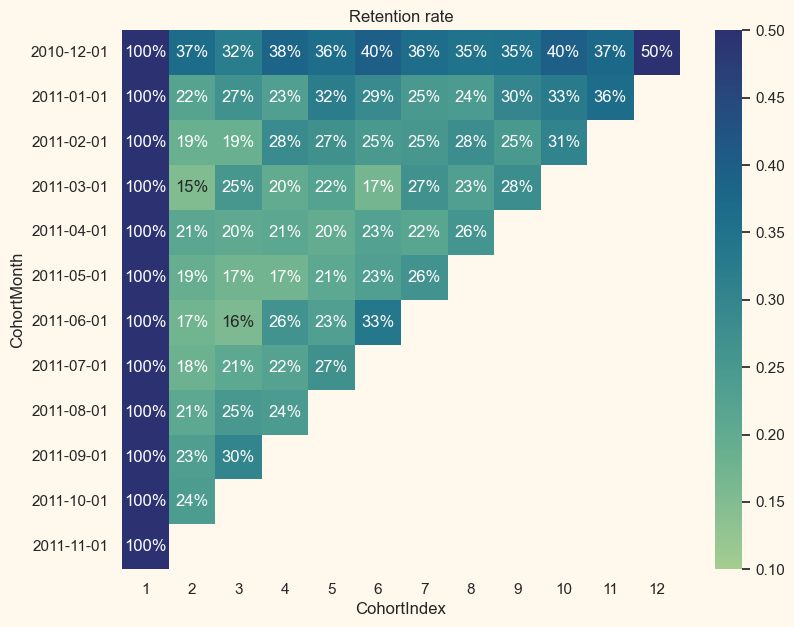

In [25]:
# visualize retention rate
plt.figure(figsize = (9, 7))
sns.heatmap(data = retention, annot=True, cmap='crest', fmt='.0%', vmin=0.1, vmax=0.5)
plt.title('Retention rate')
plt.show()

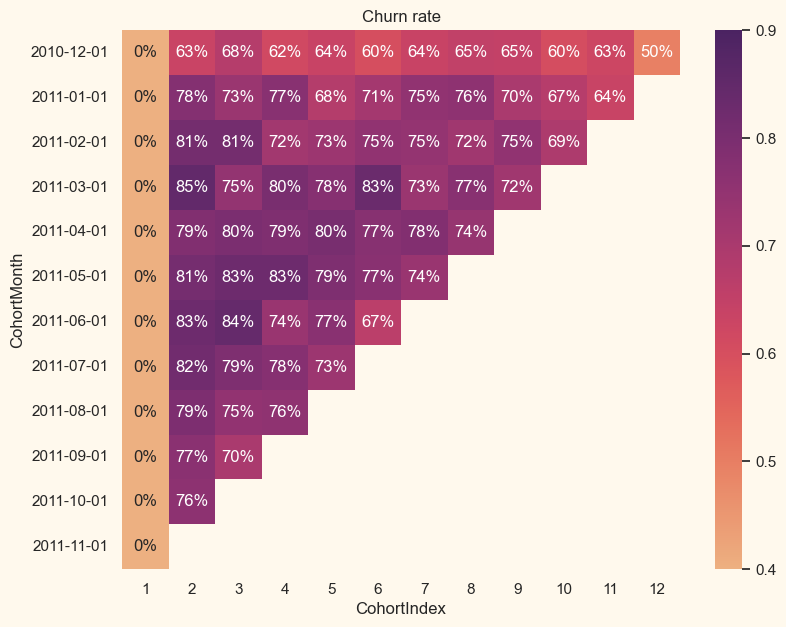

In [26]:
# visualize churn rate
plt.figure(figsize = (9, 7))
sns.heatmap(data = churn, annot=True, cmap='flare', fmt='.0%', vmin=0.4, vmax=0.9)
plt.title('Churn rate')
plt.show()

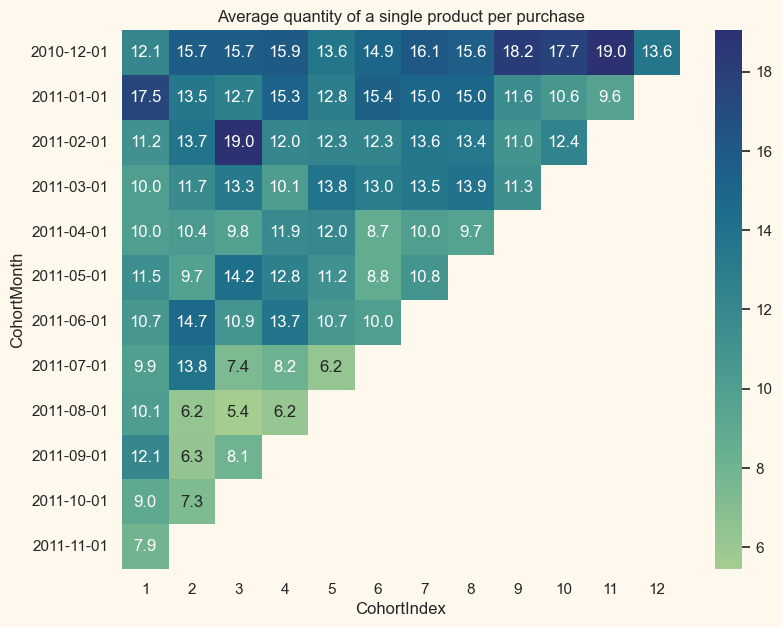

In [27]:
# visualize average quantity
plt.figure(figsize = (9, 7))
sns.heatmap(data = average_quantity, annot=True, cmap='crest', fmt='.1f')
plt.title('Average quantity of a single product per purchase')
plt.show()

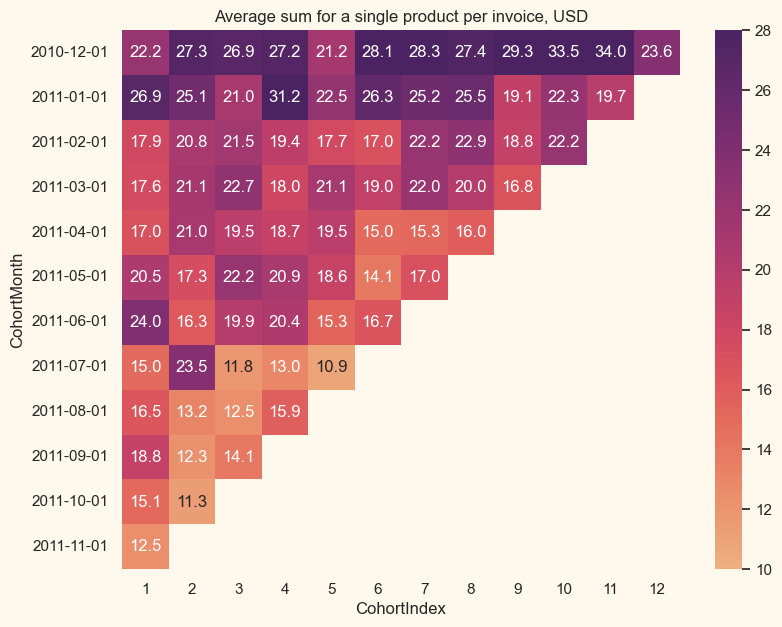

In [28]:
# visualize average invoice sum
plt.figure(figsize = (9, 7))
sns.heatmap(data = average_sum, annot=True, cmap='flare', fmt='.1f', vmin=10, vmax=28)
plt.title('Average sum for a single product per invoice, USD')
plt.show()

In [29]:
# calculate average revenue per invoice
revenue_per_purchase = df.groupby('InvoiceNo')['TotalSum'].mean().mean()

# calculate average number of unique invoices per customer per month (frequency)
frequency_per_month = df.groupby(['CustomerID', 'InvoiceMonth'])['InvoiceNo'].nunique().mean()

# define customer lifespan to 36 months
lifespan = 36

# compute CLV
clv = revenue_per_purchase * frequency_per_month * lifespan
print('Average CLV: {:.2f} USD'.format(clv))
print('Average revenue per purchase: {:.2f} USD'.format(revenue_per_purchase))
print('Average frequency per month: {:.2f}'.format(frequency_per_month))



Average CLV: 2937.14 USD
Average revenue per purchase: 57.16 USD
Average frequency per month: 1.43


## Recency, Frequency, Monetary, Tenure segmentation

In [30]:
# first, take the last invoice date and add one more day
snapshot_day = df['InvoiceDate'].max() + pd.Timedelta(days = 1)
snapshot_day

Timestamp('2011-12-01 17:37:00')

In [31]:
# calculate Recency, Frequency, Monetary variables
rfm_data = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (snapshot_day - x.max()).days, 
                                             'InvoiceNo':'count', 'TotalSum':'sum'})

# rename columns
rfm_data.rename(columns = {'InvoiceDate':'Recency', 'InvoiceNo':'Frequency', 'TotalSum':'Monetary'}, inplace = True)


# assign Tenure variable
tenure = df.groupby('CustomerID').agg({'InvoiceDate': lambda y: (snapshot_day - y.min()).days})
rfmt_data = rfm_data.assign(Tenure = tenure['InvoiceDate'])
rfmt_data.head()

,Recency,Frequency,Monetary,Tenure
CustomerID,,,,
12346,317,1,77183.60,317
12347,31,171,4085.18,359
12348,67,31,1797.24,349
12349,10,73,1757.55,10
12350,302,17,334.40,302


In [32]:
# check key statistics of rfmt_data
rfmt_data.describe()

,Recency,Frequency,Monetary,Tenure
count,4297.000000,4297.00000,4297.000000,4297.000000
mean,91.460088,87.42518,1947.874902,216.894810
std,98.574043,213.64727,8351.696003,116.449211
min,1.000000,1.00000,2.900000,1.000000
25%,16.000000,17.00000,303.160000,109.000000
50%,50.000000,40.00000,650.750000,244.000000
75%,146.000000,96.00000,1594.230000,319.000000
max,365.000000,7212.00000,268478.000000,365.000000


## Data pre-processing for clustering

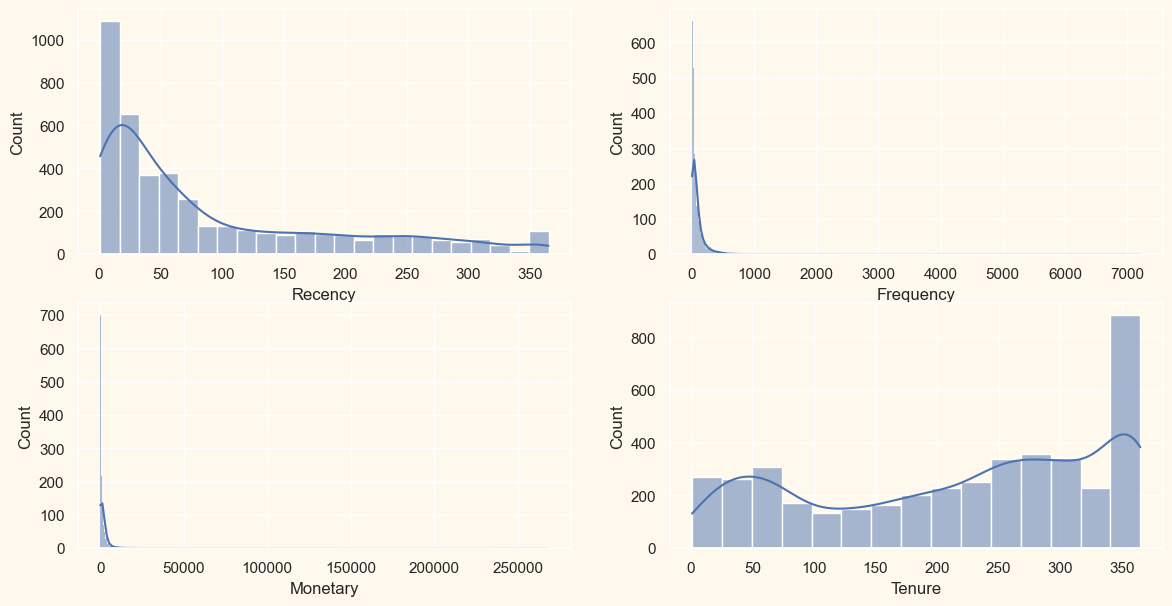

In [33]:
# check the data distribution to identify skewness
fig, ax = plt.subplots(2, 2, figsize = (14, 7))
sns.histplot(rfmt_data['Recency'], kde = True, ax = ax[0, 0])
sns.histplot(rfmt_data['Frequency'], kde = True, ax = ax[0, 1])
sns.histplot(rfmt_data['Monetary'], kde = True, ax = ax[1, 0])
sns.histplot(rfmt_data['Tenure'], kde = True, ax = ax[1, 1])
plt.show()



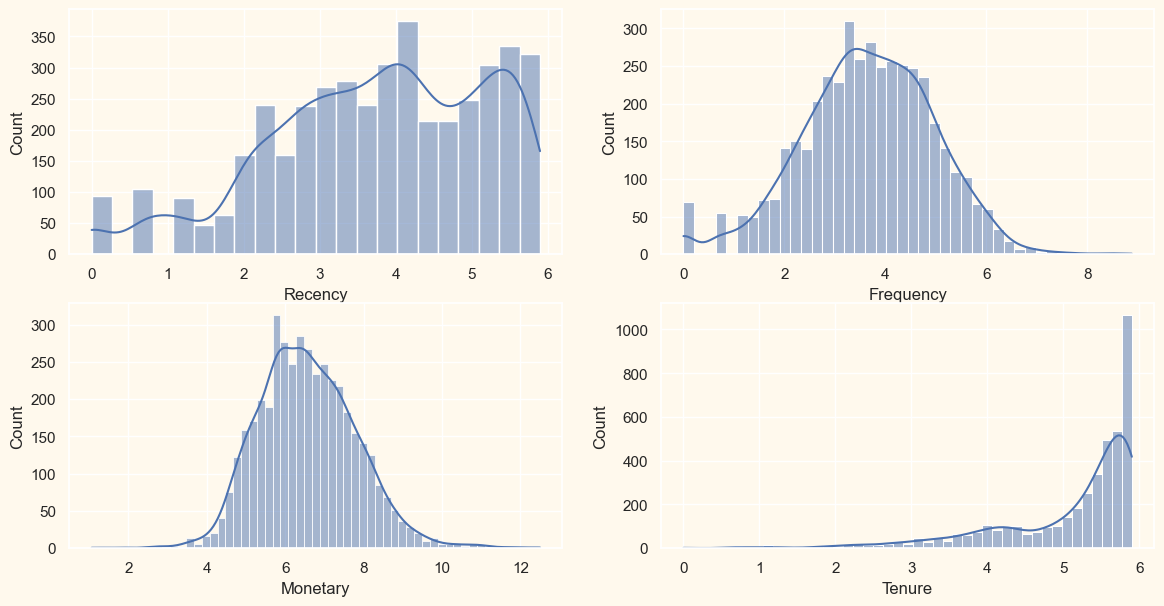

In [34]:
# apply log transformation
rfmt_data_log = np.log(rfmt_data)

# plot transform variables
fig, ax = plt.subplots(2, 2, figsize = (14, 7))
sns.histplot(rfmt_data_log['Recency'], kde = True, ax = ax[0, 0])
sns.histplot(rfmt_data_log['Frequency'], kde = True, ax = ax[0, 1])
sns.histplot(rfmt_data_log['Monetary'], kde = True, ax = ax[1, 0])
sns.histplot(rfmt_data_log['Tenure'], kde = True, ax = ax[1, 1])
plt.show()

In [35]:
# Tenure variable has skewness.
# transform data using Box-Cox transformation technique
def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox

rfmt_data_boxcox = rfmt_data.apply(boxcox_df, axis = 0)




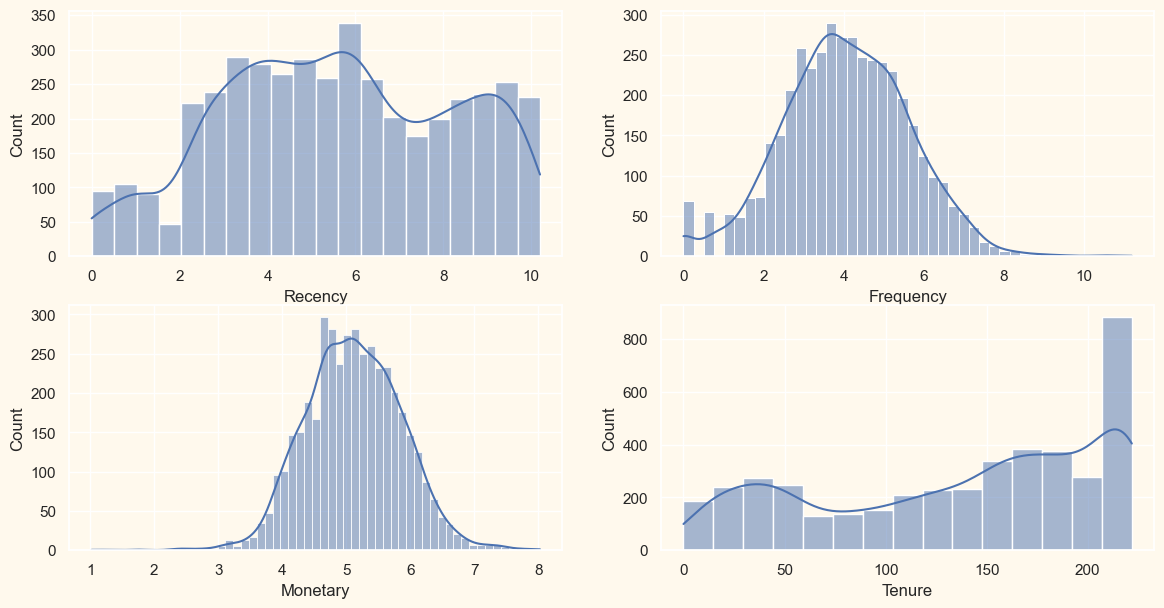

In [36]:
# check the data distribution for skewness
fig, ax = plt.subplots(2, 2, figsize = (14, 7))
sns.histplot(rfmt_data_boxcox['Recency'], kde = True, ax = ax[0, 0])
sns.histplot(rfmt_data_boxcox['Frequency'], kde = True, ax = ax[0, 1])
sns.histplot(rfmt_data_boxcox['Monetary'], kde = True, ax = ax[1, 0])
sns.histplot(rfmt_data_boxcox['Tenure'], kde = True, ax = ax[1, 1])
plt.show()

In [37]:
# check out if our data have the same mean and std
rfmt_data_boxcox.describe().round(2)

,Recency,Frequency,Monetary,Tenure
count,4297.00,4297.00,4297.00,4297.00
mean,5.59,4.05,5.11,136.21
std,2.63,1.57,0.75,69.22
min,0.00,0.00,1.02,0.00
25%,3.55,3.04,4.62,74.17
50%,5.57,4.05,5.10,154.14
75%,7.87,5.13,5.63,196.40
max,10.20,11.19,8.03,221.80


In [38]:

# normalize our data with StandardScaler()
scaler = StandardScaler()
scaler.fit(rfmt_data_boxcox)
rfmt_norm = scaler.transform(rfmt_data_boxcox)

# create pandas DataFrame
rfmt_norm = pd.DataFrame(rfmt_norm, index = rfmt_data_boxcox.index, columns = rfmt_data_boxcox.columns)

# check if normalized data have the same mean and std
rfmt_norm.describe().round(2)



,Recency,Frequency,Monetary,Tenure
count,4297.00,4297.00,4297.00,4297.00
mean,0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00
min,-2.12,-2.59,-5.45,-1.97
25%,-0.78,-0.64,-0.65,-0.90
50%,-0.01,-0.00,-0.02,0.26
75%,0.86,0.69,0.68,0.87
max,1.75,4.55,3.88,1.24


## Customer segmentation with K-means

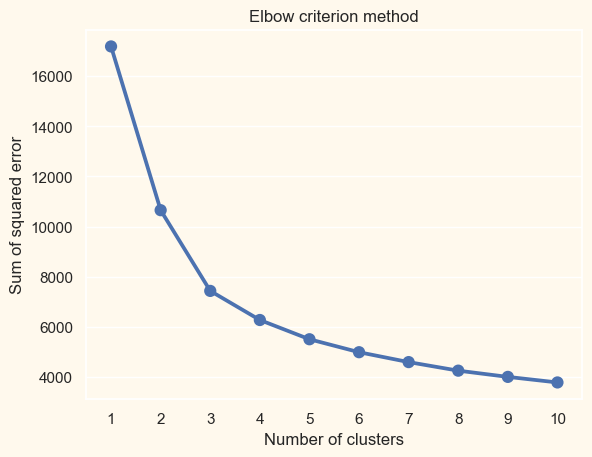

In [39]:
# calculate SSE for different number of clusters ranging from 1 to 10
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(rfmt_norm)
    sse[k] = kmeans.inertia_

# plot SSE for each 'k'
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared error')
plt.title('Elbow criterion method')
plt.show()



In [40]:
# run K-means with 3 clusters on preprocessed data
kmeans = KMeans(n_clusters = 3, random_state = 1)
kmeans.fit(rfmt_norm)

# extract cluster labels
cluster_labels_3 = kmeans.labels_

# create a Cluster column in the original dataset
rfmt_data_k3 = rfmt_data.assign(Cluster = cluster_labels_3)

# calculate average RFMT values and sizes for each cluster 
rfmt_data_k3_grouped = rfmt_data_k3.groupby('Cluster').agg({
    'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean', 'Tenure':['mean', 'count']})

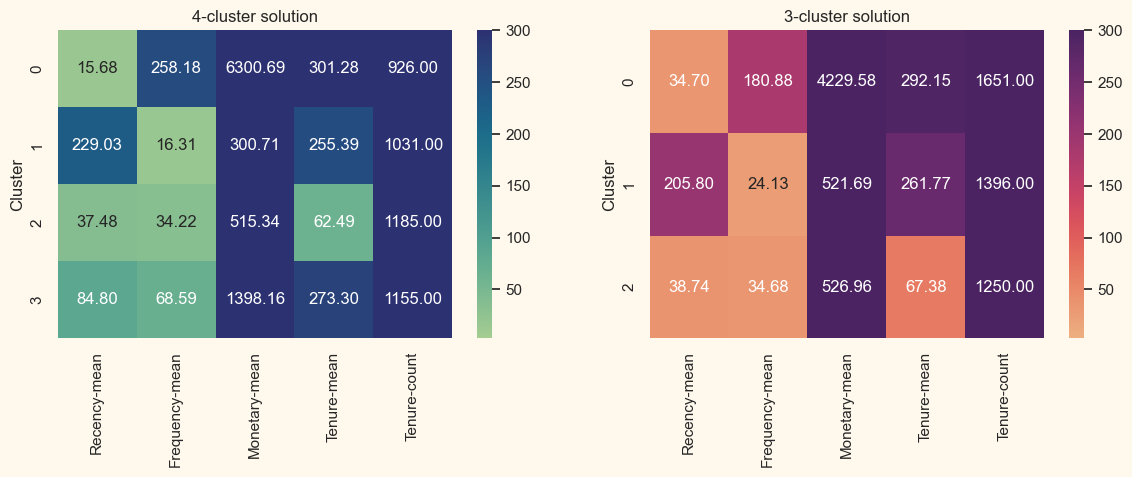

In [41]:
# run K-means with 4 clusters on preprocessed data
kmeans = KMeans(n_clusters = 4, random_state = 1)
kmeans.fit(rfmt_norm)

# extract cluster labels
cluster_labels_4 = kmeans.labels_

# create a Cluster column in the original dataset
rfmt_data_k4 = rfmt_data.assign(Cluster = cluster_labels_4)

# calculate average RFMT values and sizes for each cluster 
rfmt_data_k4_grouped = rfmt_data_k4.groupby('Cluster').agg({
    'Recency':'mean', 'Frequency':'mean', 'Monetary':'mean', 'Tenure':['mean', 'count']})

# plot both solutions
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (14, 4))
sns.heatmap(data = rfmt_data_k4_grouped, annot=True, cmap='crest', fmt='.2f', vmin=3, vmax=300, ax=ax1)
sns.heatmap(data = rfmt_data_k3_grouped, annot=True, cmap='flare', fmt='.2f', vmin=3, vmax=300, ax=ax2)
ax1.set_title('4-cluster solution')
ax2.set_title('3-cluster solution')
ax1.set_xlabel('')
ax2.set_xlabel('')
plt.show()

4-segment solution is a better choice because it provides more details, and we can immediately see the difference in RFMT values of those segments. In order to compare and understand our segments, we will create a snake plot and calculate relative importance of segment attributes. The snake plot is a visualization technique plotting segments and their RFMT values on a line plot. Relative importance of segments is the difference between our segments and overall population

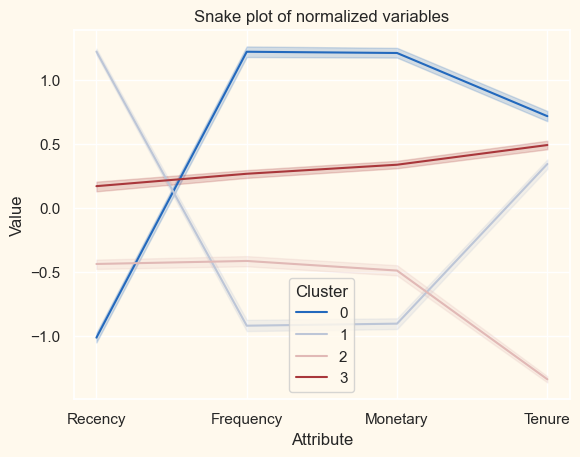

In [42]:
# visualize RFMT values between segments using snake plot
# first, add Cluster coulumn to rfmt_norm
rfmt_norm['Cluster'] = rfmt_data_k4['Cluster']

# melt rfmt_norm into the long format
rfmt_melt = pd.melt(rfmt_norm.reset_index(), id_vars = ['CustomerID', 'Cluster'], 
                    value_vars = ['Recency', 'Frequency', 'Monetary', 'Tenure'], 
                   var_name = 'Attribute', value_name = 'Value')

# create a snake plot
sns.lineplot(data = rfmt_melt, x = 'Attribute', y = 'Value', 
             hue = 'Cluster', palette = 'vlag')
plt.title('Snake plot of normalized variables')
plt.show()


The snake plot visually represents customer behavior for each cluster. We can clearly see that customers of cluster '3' bought products the most recently, the most frequently, spent the most amount of money and had the longest relationship with the company. Thus, cluster '3' represents the loyal customers named 'Loyal'. Cluster '1' customers were the least active recently, purchased the least frequently and spent the lowest amount of money. However, they had quite a long relationship with the company, that is why we can conclude that they churned and name that cluster as 'Churned'. Cluster '0' represents customers of middle performance across all four metrics, so we can name that cluster as 'Middle'. Finally, customers of cluster '2' had the shortest relationship with the company and the middle performance for the rest of the metrics. That is why it is a cluster of 'New' customers.

In [43]:
# rename the clusters to 'Loyal', 'Middle', 'New' and 'Churned'
rfmt_data_k4['Cluster'] = rfmt_data_k4['Cluster'].replace([0, 1, 2, 3], ['Middle', 'Churned', 'New', 'Loyal'])
rfmt_data_k4.head()

,Recency,Frequency,Monetary,Tenure,Cluster
CustomerID,,,,,
12346,317,1,77183.60,317,Loyal
12347,31,171,4085.18,359,Middle
12348,67,31,1797.24,349,Loyal
12349,10,73,1757.55,10,New
12350,302,17,334.40,302,Churned


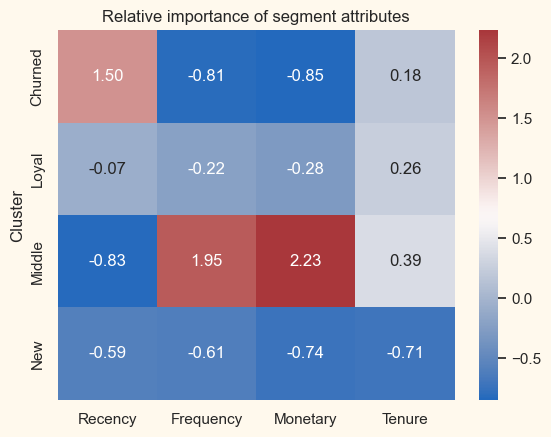

In [44]:
# compute and visualize relative importance of segment attributes
# first, calculate average RFMT values for each cluster
cluster_avg = rfmt_data_k4.groupby('Cluster').mean()

# calculate the mean for the total population
population_avg = rfmt_data.mean()

# finally, calculate importance score
relative_imp = cluster_avg / population_avg - 1

# visualize the relative scores for each claster
sns.heatmap(relative_imp, annot=True, fmt='.2f', cmap='vlag')
plt.title('Relative importance of segment attributes')
plt.show()

Zero is returned when cluster average = population average. As a ratio moves away from zero, the more important that attribute for defining a specific cluster compared to the population average. Thus, 'Monetary' is the most important attribute across three clusters except 'Churned' segment. 'Recency' is the least important for 'New' and 'Middle' clusters but the most important for 'Churned' segment. 'Frequency' is the third important attribute for 'Churned', 'Middle' and 'New' clusters and second important for 'Loyal' segment. 'Tenure' is the least important attribute for 'Churned' and 'Loyal' clusters, and second important for 'Middle' and 'New' segments.



## Conclusion

The Cohort analysis shows that the customers who had longer relationship with the company demonstrated better performance across all metrics. Thus, the overall mean retention is around 30%, but the customers in cohort 2010-12-01 had retention rate in the region of 32%-50%. Moreover, we can clearly see that in 12 months 50% of the customers returned for purchases. Customer Lifetime Value is 2937,14 USD. Now, we can use that data to calculate how much the company can invest to the customer acquisition. Also, we clustered our data into four segments – ‘Loyal’, ‘Middle’, ‘New’ and ‘Churned’ representing different customer behavior across Recency, Frequency, Monetary and Tenure metrics. Those clusters can be used for targeting or other business applications. Finally, we predicted next month customer transactions.